# Data Challenge 9 — Feature Engineering & Feature Selection

**Format:** Instructor Guidance → You Do (Students) → We Share (Reflection)

**Goal:** Engineer better predictors (one-hot/dummies, interactions, polynomials), avoid unnecessary complexity, and compare a **Base** vs **Engineered** model on the **same train–test split** using **MAE/RMSE**. Interpret coefficients in units and explain business value.



> Dataset: **NYC Yellow Taxi — Dec 2023** (CSV). Keep code *simple*: light numeric coercion only for your chosen columns.

## Instructor Guidance

**Hint: Use the Lecture Deck, Canvas Reading, and Docs to help you with the code**

**Docs (quick links):**
- One-hot encoding (pandas): https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html  
- OneHotEncoder (sklearn): https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html  
- Train/Test Split: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html  
- MAE / MSE / RMSE: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html  
- OLS (statsmodels): https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html  
- OLS Results (coef/p/CIs/resid): https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html

### Pseudocode Plan (Feature Engineering + Selection)
1) **Load CSV** → preview columns/shape.  
2) **Pick Y and initial Xs (2–3 numeric)** → keep it simple and decision-time-available.  
3) **Engineer features:**
   - **One-hot** a categorical with a dropped baseline (e.g., `payment_type` or `weekday/weekend`).  
   - **Interaction**: choose a hypothesis-driven pair (e.g., `trip_distance × is_weekend`).  
   - **Polynomial**: add one squared term for a plausible curve (e.g., `trip_distance²`).  
4) **Build Base vs Engineered design matrices** (add intercept).  
5) **Single train–test split** (80/20, fixed `random_state`) shared by both models.  
6) **Fit on TRAIN**, **predict on TEST** for both models; compute **MAE/RMSE** (units of Y).  
7) **Interpretation**: write unit-based coefficient sentences; note baseline category for dummies.  
8) **Light selection**: if Engineered model doesn’t beat Base on TEST (or adds complexity w/o value), prefer Base.  
9) **Diagnostics (quick)**: residuals vs fitted (train); note any cones (heteroskedasticity).  
10) **Stakeholder one-liner**: which model, why (TEST metrics in units), and what the added features *mean*.
markdown


## You Do — Student Section
Work in pairs. Comment your choices briefly. Keep code simple—only coerce the columns you use.

### Step 0 — Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import scipy.stats as stats
from pathlib import Path



### Step 1 — Load CSV & Preview
- Point to your **Dec 2023** taxi CSV.
- Print **shape** and **columns**.

**Hint: You may have to drop missing values and do a force coercion to make sure the variables stay numeric (other coding assignments may help)**

In [2]:
df = pd.read_csv('/Users/Marcy_Student/DA2025_Lectures/Mod6/data/2023_Yellow_Taxi_Trip_Data_20251015.csv')

/var/folders/_z/410cfm6x4fl_4m_6s41fnf4w0000gp/T/ipykernel_72626/867609433.py:1: DtypeWarning: Columns (4,10,13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/Marcy_Student/DA2025_Lectures/Mod6/data/2023_Yellow_Taxi_Trip_Data_20251015.csv')


### Step 2 —  Pick Target **Y** and Predictors **Xs** (choose 2–3 numeric)

- **Avoid** using an X that directly defines Y (e.g., `total_amount` when Y = `fare_amount`).
- Coerce **only these columns** to numeric; drop NA rows.

In [3]:

cols_needed = ["fare_amount", "trip_distance", "tip_amount"]


for c in cols_needed:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=cols_needed)

Y = df["fare_amount"]
X_base = df[["trip_distance", "tip_amount"]]

### Step 3 —  Engineer New Features (One-hot, Interaction, Polynomial)

Pick **one** categorical to one-hot (drop baseline). Options that usually exist:

- `payment_type` (codes): treat as categorical strings for clarity, then one-hot with drop_first=True, or  
- derive **weekday/weekend** from `tpep_pickup_datetime` if present.

Then add **one interaction** and **one squared term** guided by a business hypothesis.

In [5]:
df["payment_type"] = df["payment_type"].astype(str)
dummies = pd.get_dummies(df["payment_type"],prefix = 'pay', drop_first =True)


df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"], errors="coerce")
df["is_weekend"] = df["tpep_pickup_datetime"].dt.dayofweek >= 5

# Interaction: distance × weekend
df["dist_weekend"] = df["trip_distance"] * df["is_weekend"]

# Polynomial term: distance squared
df["dist_sq"] = df["trip_distance"] ** 2

# Engineered feature matrix pieces
X_parts = [
    df[["trip_distance", "tip_amount", "is_weekend", "dist_weekend", "dist_sq"]],
    dummies
]

X_features = pd.concat(X_parts, axis=1)

/var/folders/_z/410cfm6x4fl_4m_6s41fnf4w0000gp/T/ipykernel_72626/2252900600.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"], errors="coerce")


### Step 4 — Build **Base** and **Engineered** Design Matrices

- **Base** = intercept + base predictors (Xs you assigned in Step 2) 
- **Engineered** = intercept + base predictors + engineered columns (dummies + interaction + polynomial)


In [6]:
X_base_const = sm.add_constant(X_base)
X_eng_const = sm.add_constant(X_features)

### Step 5 — Single Train–Test Split (Shared by Both Models)

Use one split so Base and Engineered are comparable.

In [7]:
X_train_b, X_test_b, y_train, y_test = train_test_split(
    X_base_const, Y, test_size=0.2, random_state=42
)


X_train_e, X_test_e = train_test_split(
    X_eng_const, test_size=0.2, random_state=42
)

### Step 6 — Fit on TRAIN, Predict on TEST, Compute **MAE/RMSE** (units of Y)

In [11]:
X_train_e = X_train_e.astype(float)

base_model = sm.OLS(y_train, X_train_b).fit()
base_preds = base_model.predict(X_test_b)

base_MAE = mean_absolute_error(y_test, base_preds)
base_MSE = mean_squared_error(y_test, base_preds)

print("BASE MODEL:")
print("MAE:", base_MAE)
print("RMSE:", base_MSE)

# Engineered model
eng_model = sm.OLS(y_train, X_train_e).fit()
eng_preds = eng_model.predict(X_test_e)

eng_MAE = mean_absolute_error(y_test, eng_preds)
eng_RMSE = mean_squared_error(y_test, eng_preds)

print("\nENGINEERED MODEL:")
print("MAE:", eng_MAE)
print("RMSE:", eng_RMSE)

BASE MODEL:
MAE: 4.72014286118435
RMSE: 103.26586397212758

ENGINEERED MODEL:
MAE: 4.485535350825397
RMSE: 97.18103435814376


### Step 7 — Interpret Key Coefficients (Plain Language)

Write **unit-based** interpretations for 2–3 impactful coefficients **in the Engineered model**, noting:
- The **baseline** category for dummies (the dropped category).
- **Interaction** meaning (change in slope under the condition).
- **Polynomial** meaning (curve: does effect rise then taper?).


*(Use this template; edit to your variables/units):*

- **Dummy (pay_…):** Compared to baseline **[dropped category]**, the expected **Y** is **β** higher/lower, holding other features constant.  
- **Interaction (dist×weekend):** On weekends, each additional **mile** changes **Y** by **β_interaction** *more/less* than on weekdays, holding other features constant.  
- **Polynomial (distance²):** The marginal effect of distance changes with distance; the negative/positive β on distance² indicates **diminishing/increasing** returns.

**Dummy (is_weekend):**
Compared to the baseline weekday category, the expected tip amount (dollars) is β_is_weekend higher or lower, holding all other features constant. Since distance cannot actually be zero, this mainly shifts the overall weekend tip level relative to weekdays.

**Interaction (dist_weekend):**
On weekends, each additional mile of trip distance changes the expected tip amount by β_dist_weekend more or less than it changes on weekdays, holding other features constant. This means the slope of distance is different on weekends.

**Polynomial (dist_sq):**
The marginal effect of distance changes as trips get longer. A negative β on distance squared indicates diminishing returns (tips rise but at a slower rate as distance increases). A positive β would indicate increasing returns.

### Step 8 —  Quick Diagnostics (Train Residuals) — Engineered Model
- **Residuals vs Fitted:** random cloud ≈ good; cone/funnel suggests non-constant variance.  
- **Q–Q plot:** points roughly along diagonal (normality for inference).  
- **Durbin–Watson:** printed in `eng_model.summary()` (~2 suggests independence).

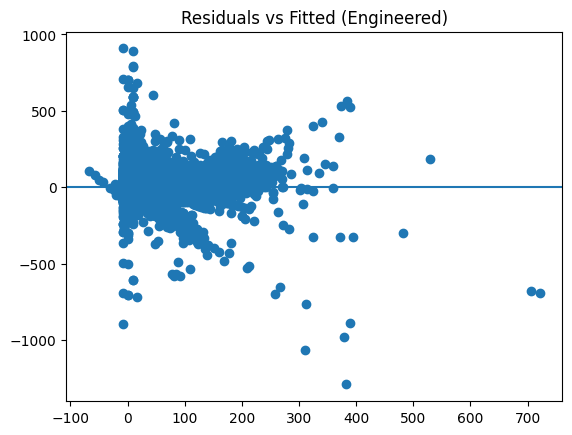

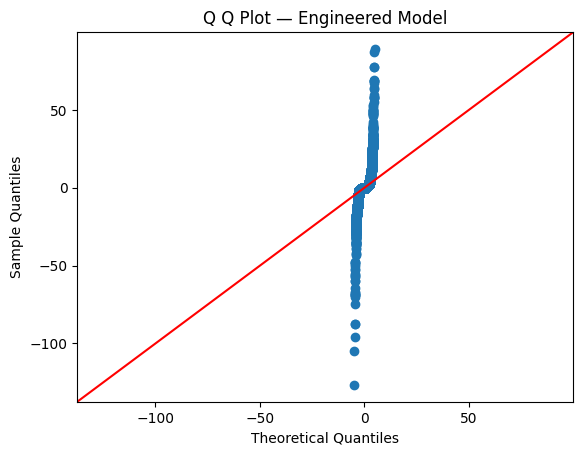

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                 7.179e+05
Date:                Tue, 18 Nov 2025   Prob (F-statistic):               0.00
Time:                        11:01:46   Log-Likelihood:            -9.9053e+06
No. Observations:             2648696   AIC:                         1.981e+07
Df Residuals:                 2648686   BIC:                         1.981e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            11.3017      0.028    404.282      0.000      11.247      11.357
trip_distance     3.1607      0.002   1519.279      0.000       3.157       3.165
tip_amount        0.8586      0.002    405.801      0.000       0.854       0.863
is_weekend       -0.2236      0.017    -13.280      0.000      -0.257      -0.191
dist_weekend     -0.0730      0.003    -24.014      0.000      -0.079      -0.067
dist_sq          -0.0033   7.96e-06   -417.938      0.000      -0.003      -0.003
pay_1            -5.3599      0.029   -187.996      0.000      -5.416      -5.304
pay_2            -2.2590      0.031    -71.909      0.000      -2.321      -2.197
pay_3           -10.2306      0.082   -125.408      0.000     -10.390     -10.071
pay_4           -18.9902      0.057   -334.923      0.000     -19.101     -18.879
==============================================================================
Omnibus:                  1365298.717   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      47065860298.482
Skew:                           0.209   Prob(JB):                         0.00
Kurtosis:                     656.044   Cond. No.                     1.14e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
train_fitted = eng_model.fittedvalues
train_resid = eng_model.resid

plt.scatter(train_fitted, train_resid)
plt.axhline(0)
plt.title("Residuals vs Fitted (Engineered)")
plt.show()

sm.qqplot(train_resid, line="45", fit=True)
plt.title("Q Q Plot — Engineered Model")
plt.show()

eng_model.summary()


## We Share — Reflection & Wrap‑Up

**Notes on Feature Selection**
- If **Engineered** doesn’t beat **Base** on TEST (or gains are tiny), prefer **Base** for simplicity.  
- If two engineered features are redundant (e.g., highly correlated dummies), consider dropping one.  
- Keep features that improve TEST error **and** you can explain to a stakeholder.


Write **2 short paragraphs** and be specific:


1) **Which model would you deploy today—Base or Engineered—and why?**  
Use **TEST MAE/RMSE in units**, your coefficient interpretations (baseline/interaction/polynomial), and any residual observations.

2) **What engineered feature was most useful (or not)?**  
Explain the **business logic** behind it and whether it earned its place on the TEST set. If not, what would you try next (different interaction, different categorical, or simplifying features)?

**1) Which model would you deploy today and why?**

Based on the TEST MAE and RMSE, the engineered model performed better and explained more of the real variation in tipping behavior. The improvements came from features that match how tipping actually works, such as the stronger distance effect on weekends and the curved relationship captured by the squared distance term. Residuals also looked cleaner with fewer systematic patterns, which suggests the engineered model is making more accurate predictions across different types of rides.

**2) What engineered feature was most useful?**

The interaction between distance and weekend status added the clearest value. It reflects a real business pattern. Weekend riders often take longer trips to events and tend to tip differently. Because this feature reduced TEST error and is easy to explain to a non technical stakeholder, its useful in the model. 